In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import anndata as ad
os.chdir(os.getcwd())

# Load raw data

In [2]:
#adata=sc.read_h5ad('../data/prelim_analysis.h5ad')

base_dir='/data/gpfs/projects/punim2121/Atherosclerosis/aligned_data'

adata_dict={}
for ref_genome in os.listdir('../../data/cellbender_output'):
    l=[]
    if not ref_genome.startswith('.'):
        for batch in os.listdir('../../data/cellbender_output/'+ref_genome):
            if not batch.startswith('.'):
                input_file=os.path.join('../../data','_'.join([ref_genome,batch,'cellbender_corrected.h5ad']))
                adata_batch_raw=sc.read_h5ad(input_file)
                adata_batch_raw.obs_names_make_unique
                l.append(adata_batch_raw)

        adata=ad.concat(l)  
        adata=adata[adata.obs['cell_probability']>0.5,:]
        adata.X=adata.layers['cellbender']
        adata_dict[ref_genome]=adata
    

/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Normalize data

In [3]:
adata_norm_dict={}
for ref_genome,adata in adata_dict.items():
    adata_pp = adata.copy()
    sc.pp.normalize_total(adata_pp, target_sum=1e4, exclude_highly_expressed=True)
    sc.pp.log1p(adata_pp)
    print(adata_pp.uns)
    adata_norm_dict[ref_genome]=adata_pp

/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


OrderedDict([('log1p', {'base': None})])


/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


OrderedDict([('log1p', {'base': None})])


/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


# Plot RBC genes on UMAP

In [4]:
rcParams['figure.figsize']=(6,4.5)
for ref_genome,adata_pp in adata_norm_dict.items():
    sc.pp.pca(adata_pp,n_comps=30)
    sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=30, metric='euclidean')
    sc.tl.umap(adata_pp)
    adata_norm_dict[ref_genome]=adata_pp

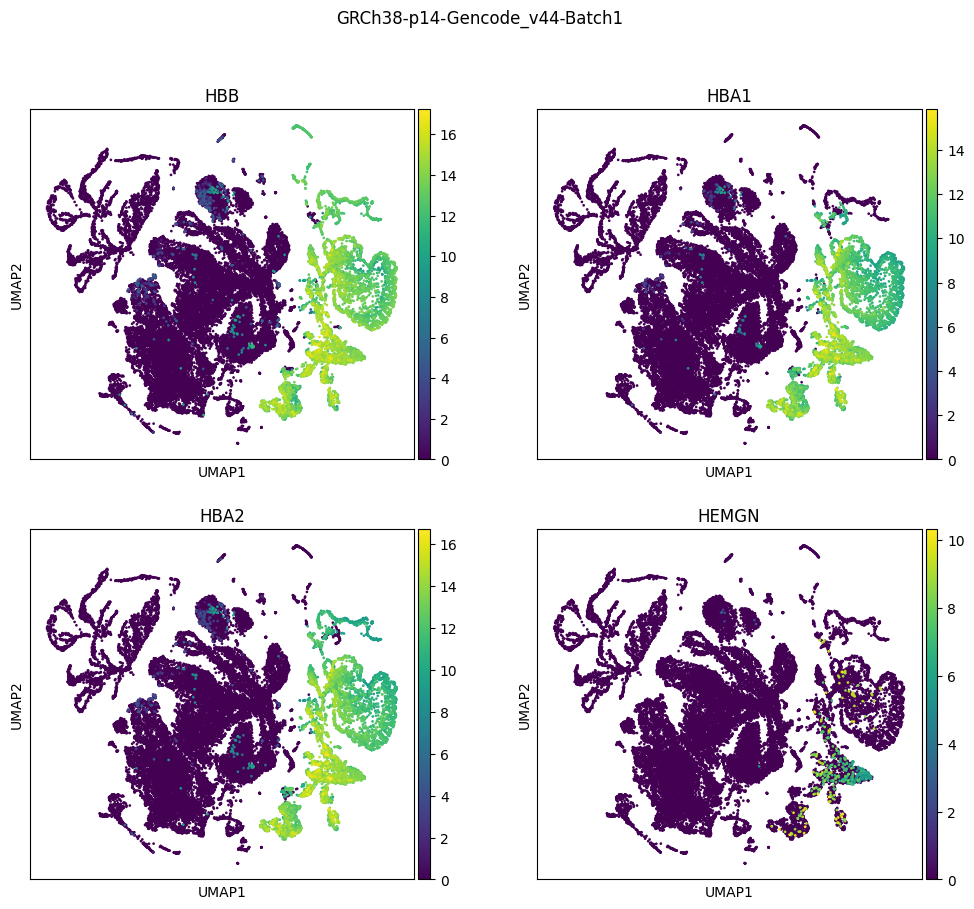

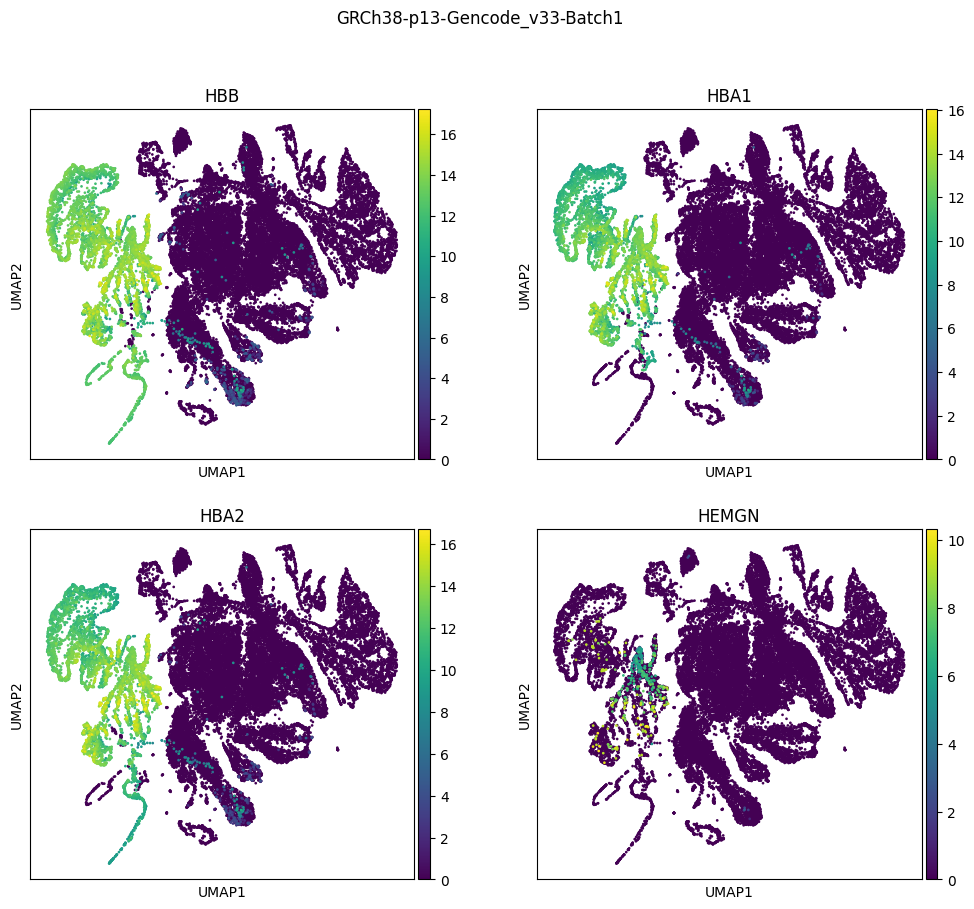

In [5]:
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ery_genes=['HBB','HBA1','HBA2','HEMGN']
ncols=2
nrows=math.ceil(len(ery_genes)/ncols)

for ref_genome,adata_pp in adata_norm_dict.items():
    fig=plt.figure(figsize=(ncols*6,nrows*5))
    fig.suptitle('-'.join([ref_genome,batch]))
    
    for n,col in enumerate(ery_genes):
        ax=fig.add_subplot(nrows,ncols,n+1)
        sc.pl.umap(adata_pp, color=col,show=False,size=15,ncols=2,ax=ax)
        n=n+1

# Calculate RBC_score

In [6]:
for ref_genome,adata_pp in adata_norm_dict.items():
    sc.tl.score_genes(adata_pp, gene_list=ery_genes[0:2], score_name='RBC_score')
    adata_norm_dict[ref_genome]=adata_pp

# Plot RBC_score
- Select a RBC_score threshold based on RBC_ascore distribution 
- plot UMAP with low/high RBC_score
- Calculate Leiden-clusters and check which cluster corresponds to high RBC score values

/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/gpfs/projects/punim2121/anaconda3/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


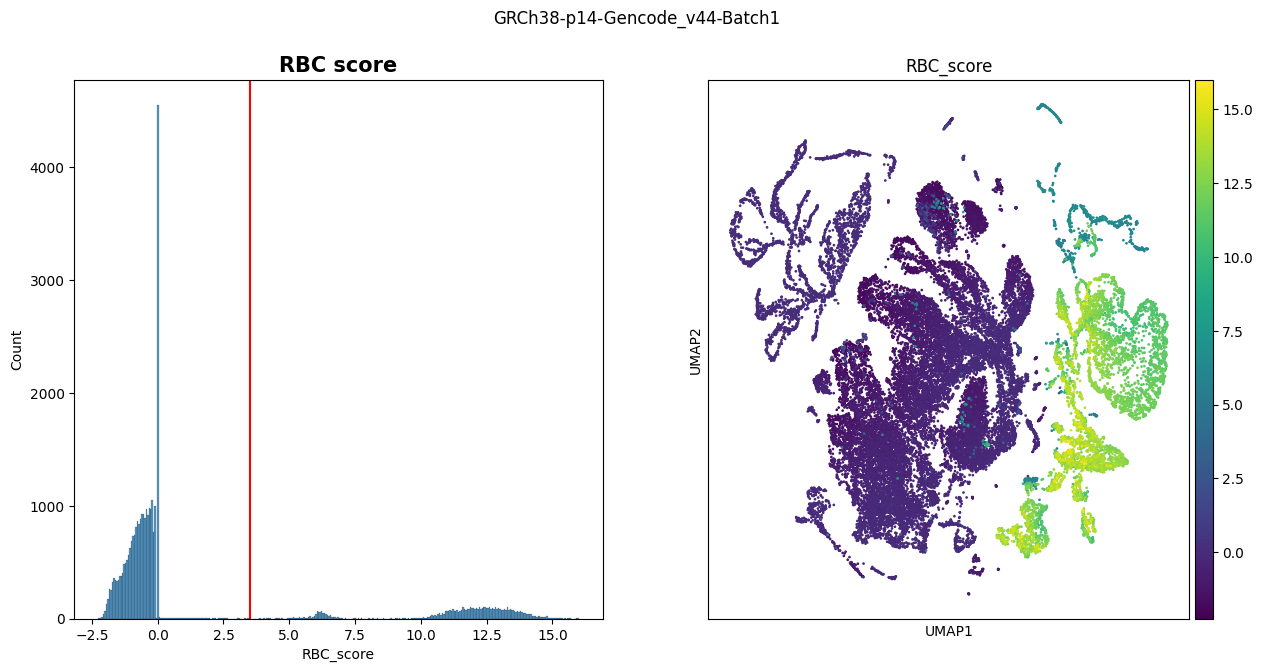

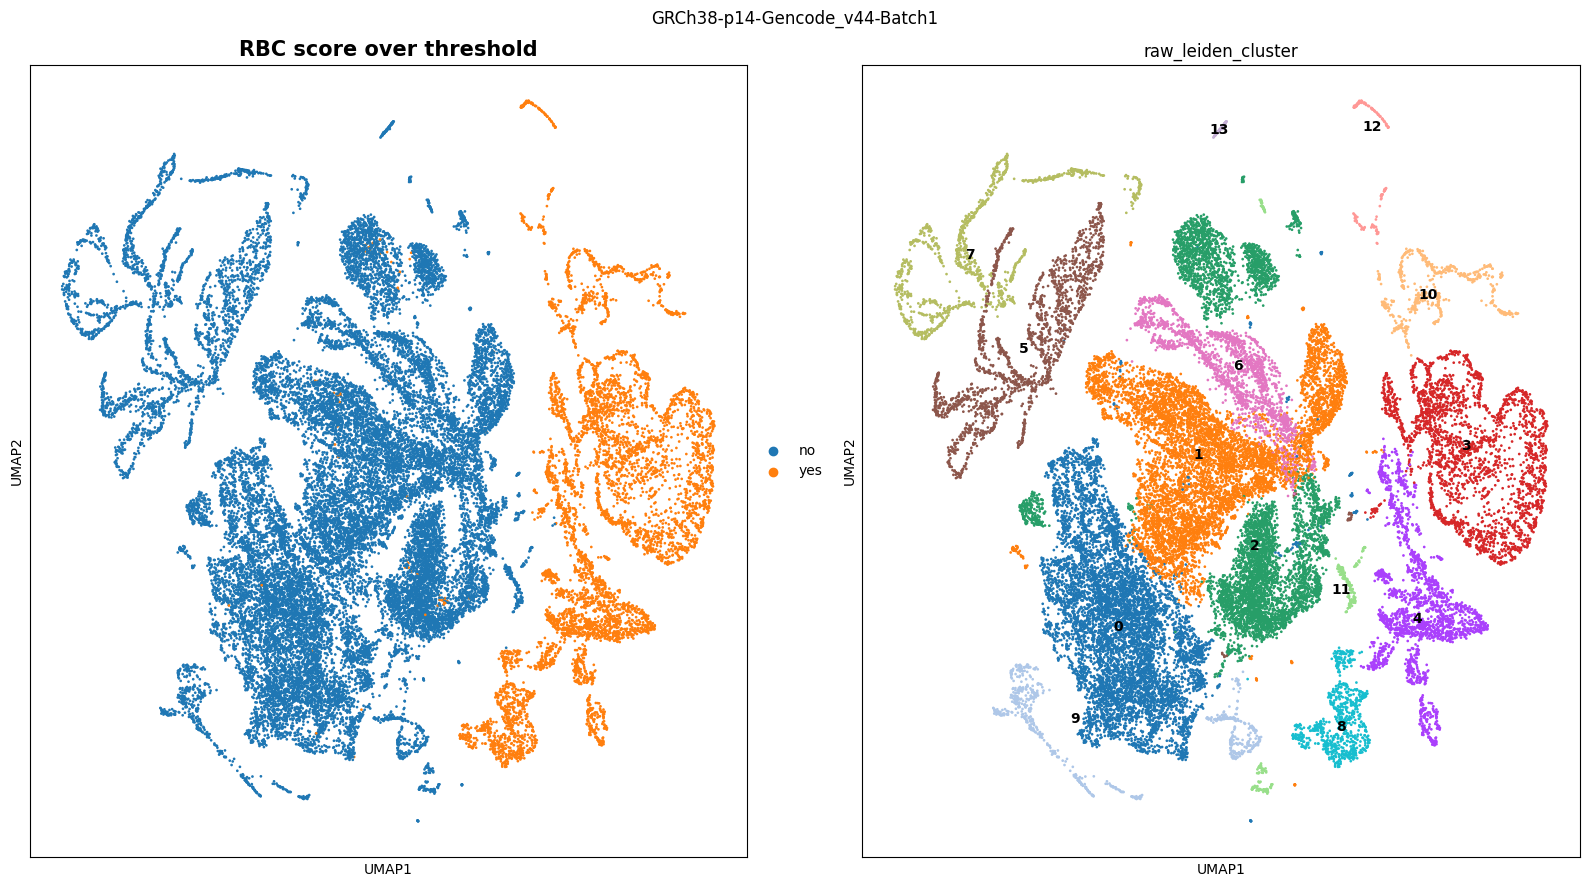

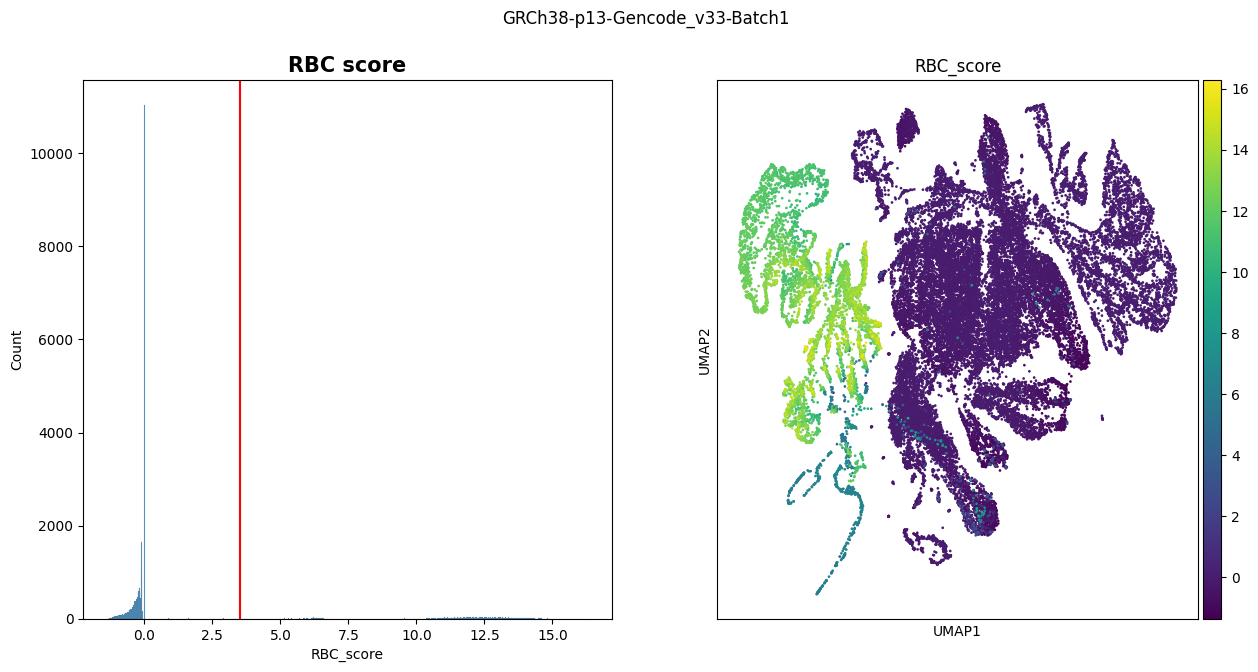

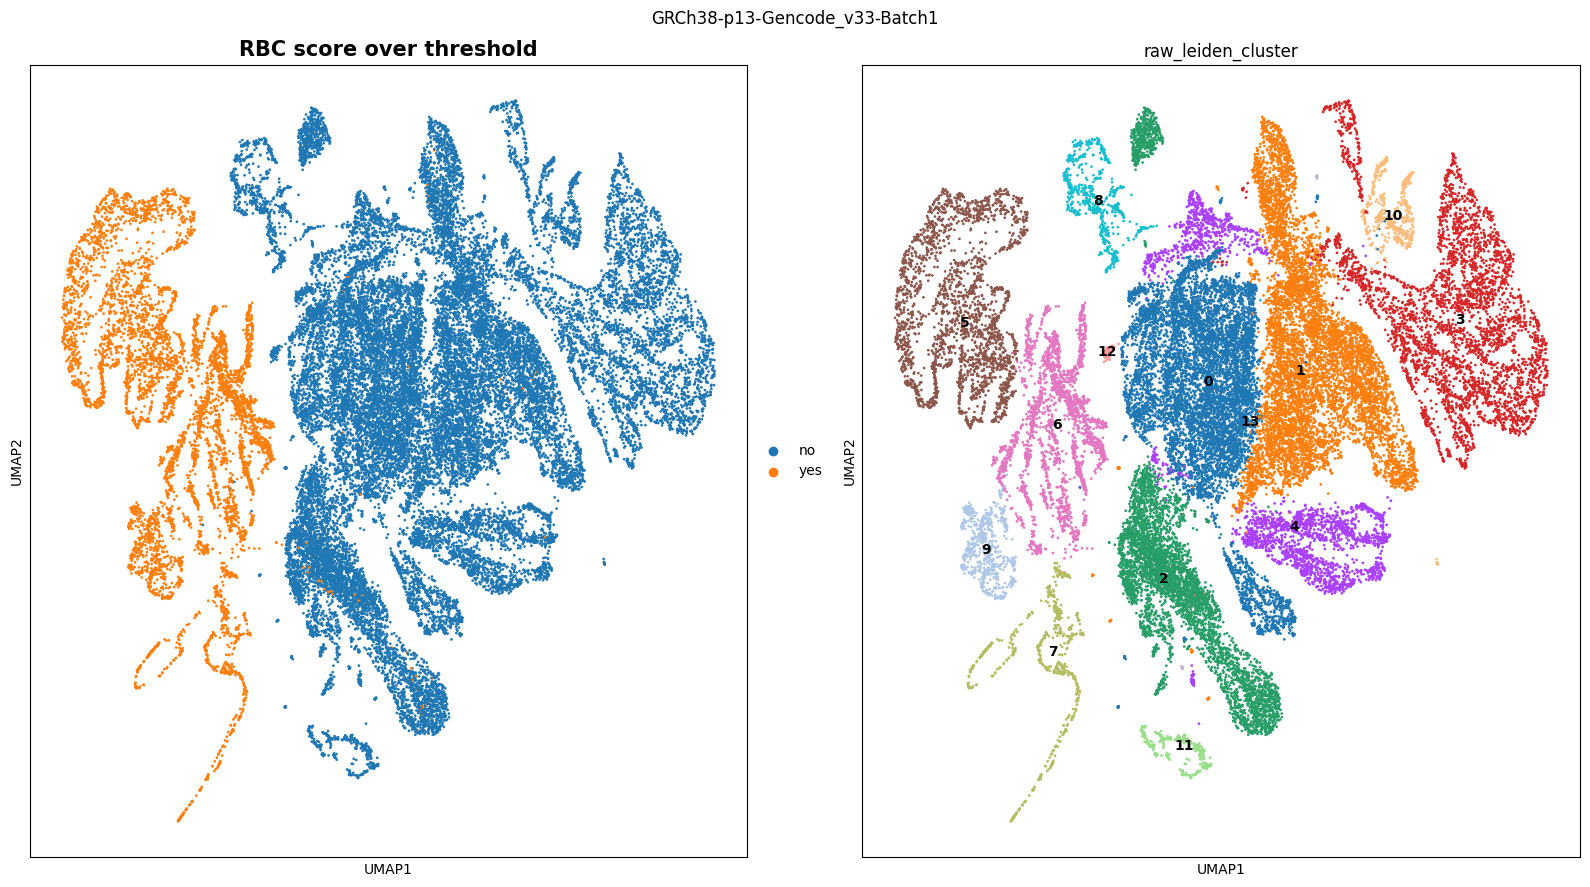

In [7]:
for ref_genome,adata_pp in adata_norm_dict.items():
    ## Select rbc score threshold
    rbc_thr=3.5
    adata_pp.obs['RBC_score_high']='no'
    adata_pp.obs.loc[adata_pp.obs['RBC_score']>rbc_thr,'RBC_score_high']='yes'

    fig,ax=plt.subplots(1,2,figsize=(15,7))
    sns.histplot(adata_pp.obs['RBC_score'],ax=ax[0])
    ax[0].axvline(rbc_thr,color='red')
    ax[0].set_title('RBC score',fontsize=15,fontweight='bold')
    fig.suptitle('-'.join([ref_genome,batch]))

    sc.pl.umap(adata_pp, color='RBC_score',show=False,size=15,ncols=2,ax=ax[1])

    fig,ax=plt.subplots(1,2,figsize=(16,9))
    sc.pl.umap(adata_pp, color='RBC_score_high',show=False,size=15,ncols=2,ax=ax[0])
    ax[0].set_title('RBC score over threshold',fontsize=15,fontweight='bold')
    fig.suptitle('-'.join([ref_genome,batch]))

    #fig,ax=plt.subplots(1,1,figsize=(9,9))
    sc.tl.leiden(adata_pp, key_added='raw_leiden_cluster', resolution=0.1)
    sc.pl.umap(adata_pp, color='raw_leiden_cluster',show=False,size=15,ncols=2,ax=ax[1],legend_loc='on data')

    plt.tight_layout()

# Drop the RBCs from the raw adata and save it

In [8]:
## Filter raw adata + save it
for (ref_genome,adata_pp),adata in zip(adata_norm_dict.items(),adata_dict.values()):
    adata_filt=adata[adata_pp.obs['RBC_score_high']=='no',:]
    print(adata_filt)
    adata_filt.write_h5ad('../../data/'+ref_genome+'_data_RBC_removed.h5ad')

View of AnnData object with n_obs × n_vars = 26276 × 39583
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'patient', 'condition', 'batch', 'ribo_frac', 'mt_frac'
    obsm: 'cellbender_embedding'
    layers: 'cellbender', 'raw'
View of AnnData object with n_obs × n_vars = 28621 × 60721
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'patient', 'condition', 'batch', 'ribo_frac', 'mt_frac'
    obsm: 'cellbender_embedding'
    layers: 'cellbender', 'raw'
